In [1]:
##### ✅ PART 1: Load Data and Create Labels
import pandas as pd

TRAIN_PATH = (
    r"C:\Users\Sina\Desktop\CODES\Sources\5(CLASSIFICATION)\1(NAIVEBAYES)\1(user_courses_review_09_2023).csv"
)
TEST_PATH = (
    r"C:\Users\Sina\Desktop\CODES\Sources\5(CLASSIFICATION)\1(NAIVEBAYES)\2(user_courses_review_test_set).csv"
)

# Load separate files
df_train = pd.read_csv(TRAIN_PATH, on_bad_lines="skip", quotechar='"')
df_test  = pd.read_csv(TEST_PATH,  on_bad_lines="skip", quotechar='"')

# Standard column names
df_train.columns = ["course_name", "lecture_name", "review_rating", "review_comment"]
df_test.columns  = ["course_name", "lecture_name", "review_rating", "review_comment"]

# Clean each set
for df in (df_train, df_test):
    df.dropna(subset=["review_rating", "review_comment"], how="all", inplace=True)
    df["review_comment"] = df["review_comment"].fillna("")
    df["review_rating"]  = pd.to_numeric(df["review_rating"], errors="coerce")
    df.dropna(subset=["review_rating"], inplace=True)
    df["label"] = df["review_rating"].apply(lambda x: 1 if x >= 4 else 0)

# Keep only what we need
df_train = df_train[["review_comment", "label"]]
df_test  = df_test[["review_comment", "label"]]
df_test

,review_comment,label
0,perfect,1
1,The SCRUM chapter are full of errors,0
2,Bad quality of audio and narrative,0
3,I need documentation about lecture.,0
4,Great course! Ned has a talent for explaining ...,1
...,...,...
149,NOT WORTH IT,0
150,Nice,1
151,Information was great.,1
152,great\n,1


In [2]:
##### ✅ PART 2: Text Pre-processing (unchanged)
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text  = text.lower()
    text  = text.translate(str.maketrans("", "", string.punctuation))
    text  = re.sub(r"\d+", "", text)
    words = [
        lemmatizer.lemmatize(w)
        for w in text.split()
        if w not in stop_words
    ]
    return " ".join(words)

df_train["cleaned_comment"] = df_train["review_comment"].apply(clean_text)
df_test["cleaned_comment"]  = df_test["review_comment"].apply(clean_text)


<ipython-input-2-ab7f787f4018>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["cleaned_comment"]  = df_test["review_comment"].apply(clean_text)


In [3]:
##### ✅ PART 3: Vectorise + SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

X_train_raw = df_train["cleaned_comment"]
y_train     = df_train["label"]
X_test_raw  = df_test["cleaned_comment"]
y_test      = df_test["label"]

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf  = vectorizer.transform(X_test_raw)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)


In [4]:
##### ✅ PART 4: Train Naive Bayes and SVM, combine predictions with weighted voting

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_balanced, y_train_balanced)

# Train SVM
svm_model = LinearSVC(random_state=42, max_iter=10000)
svm_model.fit(X_train_balanced, y_train_balanced)

# Get predicted probabilities for Naive Bayes
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]

# Get decision function scores from SVM and convert to probabilities using a simple logistic function
# (LinearSVC does not have predict_proba by default)
svm_scores = svm_model.decision_function(X_test_tfidf)
svm_probs = 1 / (1 + np.exp(-svm_scores))  # sigmoid to convert to probabilities

# Weighted average of probabilities (weights can be tuned)
w_nb = 0.5
w_svm = 0.5
hybrid_probs = w_nb * nb_probs + w_svm * svm_probs

# Convert probabilities to class labels using threshold 0.5
hybrid_preds = (hybrid_probs >= 0.5).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Hybrid Model Accuracy: 0.8636363636363636 

Hybrid Model Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.87      0.55        15
           1       0.98      0.86      0.92       139

    accuracy                           0.86       154
   macro avg       0.69      0.86      0.74       154
weighted avg       0.93      0.86      0.88       154



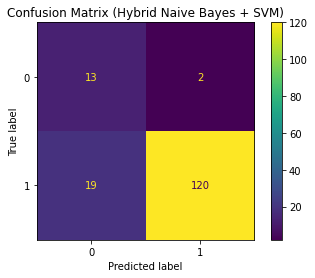

In [5]:
##### ✅ PART 5: Evaluate hybrid model

print("Hybrid Model Accuracy:", accuracy_score(y_test, hybrid_preds), "\n")
print("Hybrid Model Classification Report:\n", classification_report(y_test, hybrid_preds))

ConfusionMatrixDisplay.from_predictions(y_test, hybrid_preds)
plt.title("Confusion Matrix (Hybrid Naive Bayes + SVM)")
plt.show()

In [ ]:
"""Why did this work well?

    Naive Bayes and SVM have complementary strengths, and combining their outputs via soft voting leverages their different decision boundaries and confidence levels.

    Using probabilities (or calibrated scores) rather than hard votes allows a smoother combination.

    Equal weighting (0.5, 0.5) worked well, but you can experiment with tuning these weights to possibly improve further."""

In [11]:
##### ✅ PART 6: Extract Positive and Negative Words

import numpy as np
import pandas as pd

# Get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# --- Importance from Naive Bayes ---
nb_importance = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]

# --- Importance from SVM ---
svm_importance = svm_model.coef_[0]  # positive => positive sentiment

# --- Hybrid importance (average of both) ---
hybrid_importance = (nb_importance + svm_importance) / 2

# Sort all features from most negative to most positive
sorted_indices = np.argsort(hybrid_importance)

all_negative_words = feature_names[sorted_indices]  # from most negative to less negative
all_positive_words = feature_names[sorted_indices[::-1]]  # from most positive to less positive


pd.DataFrame({
    'Positive_Words': all_negative_words,
    'Negative_Words':all_positive_words
})


,Positive_Words,Negative_Words
0,generic,excellent
1,choose,amazing
2,farther,perfect
3,poorly,nice
4,nothing,expectation
...,...,...
4510,expectation,nothing
4511,nice,poorly
4512,perfect,farther
4513,amazing,choose


In [15]:
import pandas as pd

# Create and sort DataFrame
df_scores = pd.DataFrame({
    'Word': feature_names,
    'Hybrid_Score': hybrid_importance
}).sort_values('Hybrid_Score', ascending=False)


df_scores

# Save to Excel
df_scores.to_excel("hybrid_word_scores.xlsx", index=False)

print("✅ Excel file 'hybrid_word_scores.xlsx' saved successfully.")


<ipython-input-15-4aeee41f6154>:13: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  df_scores.to_excel("hybrid_word_scores.xlsx", index=False)


✅ Excel file 'hybrid_word_scores.xlsx' saved successfully.


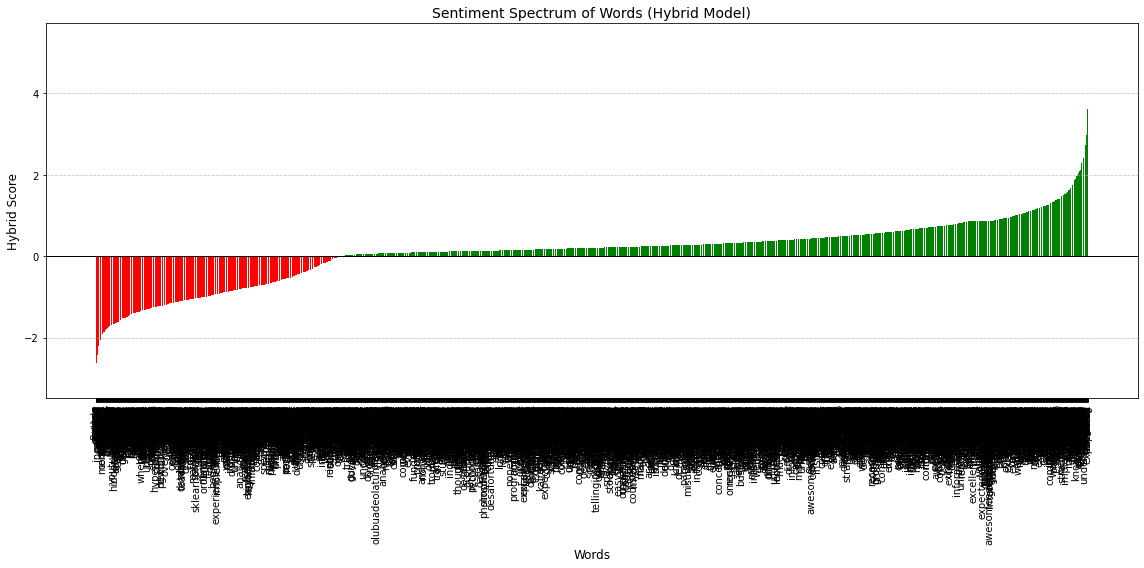

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the file
df = pd.read_excel("hybrid_word_scores.xlsx")

# 2. Drop rows with missing values in 'Word' or 'Hybrid_Score'
df = df.dropna(subset=["Word", "Hybrid_Score"])

# 3. Convert all Word values to strings
df["Word"] = df["Word"].astype(str)

# 4. Sort by score
df_sorted = df.sort_values("Hybrid_Score", ascending=True)

# 5. Color mapping: red for negative, green for positive
colors = ['red' if score < 0 else 'green' for score in df_sorted['Hybrid_Score']]

# 6. Plot
plt.figure(figsize=(16, 8))
plt.bar(df_sorted['Word'], df_sorted['Hybrid_Score'], color=colors)

# Labels and title
plt.xlabel("Words", fontsize=12)
plt.ylabel("Hybrid Score", fontsize=12)
plt.title("Sentiment Spectrum of Words (Hybrid Model)", fontsize=14)
plt.xticks(rotation=90)

# Horizontal line at zero
plt.axhline(0, color='black', linewidth=1)

# Grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


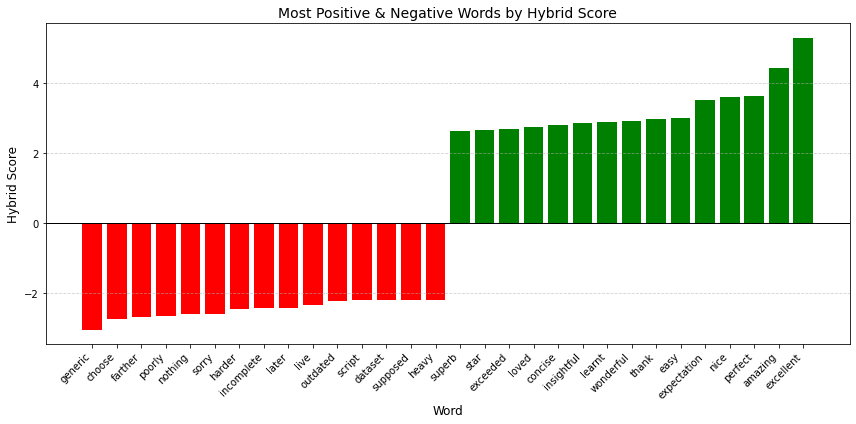

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean
df = pd.read_excel("hybrid_word_scores.xlsx")
df = df.dropna(subset=["Word", "Hybrid_Score"])
df["Word"] = df["Word"].astype(str)

# Sort
df_sorted = df.sort_values("Hybrid_Score", ascending=True)

# Select top 15 negative and top 15 positive
top_neg = df_sorted.head(15)
top_pos = df_sorted.tail(15)
df_plot = pd.concat([top_neg, top_pos])

# Color mapping
colors = ['red' if score < 0 else 'green' for score in df_plot['Hybrid_Score']]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df_plot['Word'], df_plot['Hybrid_Score'], color=colors)

# Formatting
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Hybrid Score", fontsize=12)
plt.xlabel("Word", fontsize=12)
plt.title("Most Positive & Negative Words by Hybrid Score", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
